Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier
# XGBoost 
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13


import os
import json
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import keras_tuner
from kerastuner.engine.trial import Trial
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import StandardScaler

#rng = np.random.default_rng(1758)


XGBoost version: 2.1.1


2025-04-01 17:22:01.905182: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_86575/1366471999.py:26: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.trial import Trial


Read and split data

In [35]:
def Standardize(x):
    """
    Rescales each component using its mean and standard deviation
    """
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x,axis=0)
    N = len(x)
    # assuming len(m)=len(s)=len(x[0])
    mm,ss = np.tile(x_mean,(N,1)), np.tile(x_std,(N,1))
    return (x-mm)/ss

In [36]:
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_25.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
x = Standardize(x)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")

N=5000, N_train=3750, L=4


show training and test sets

[-1.11727948 -1.0201866   0.25886405  0.30046464] 0
[1.5880603  0.52481408 0.88059141 0.50161929] 0
[ 0.83668292  1.58598179 -1.66053643 -1.39494703] 0
[-0.71947923  0.53593786  1.08957251  1.25940695] 0
[1.5885455  0.76764319 0.51537205 0.72305233] 0


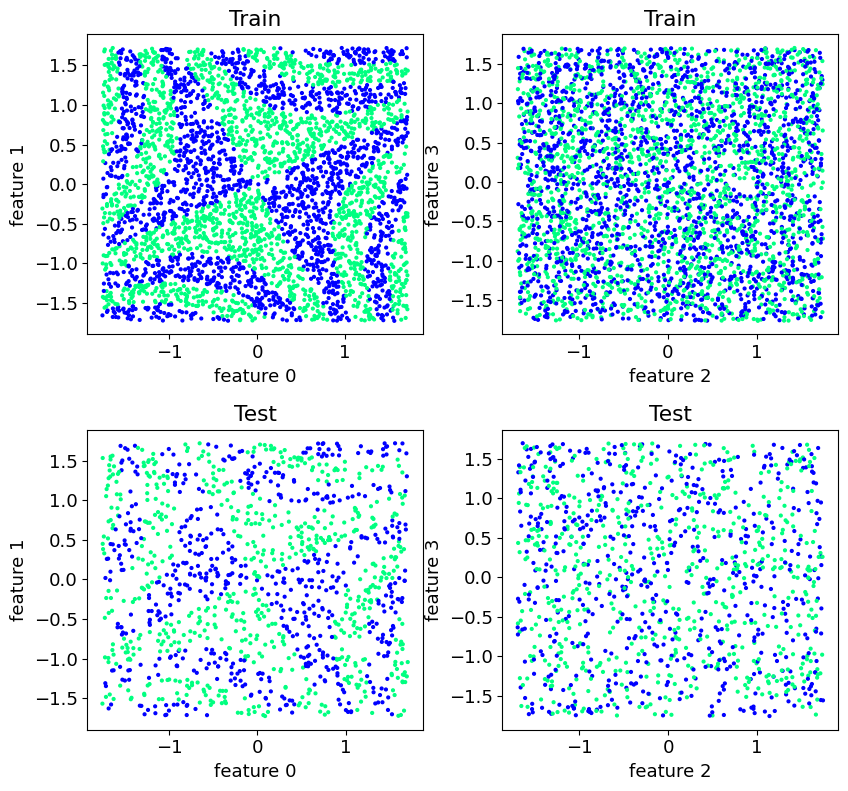

In [41]:
def scat(ax,x,y,i=0,j=1,s=4,title=""):
    ax.scatter(x[:,i],x[:,j],s=s,c=y)
    ax.set_xlabel(f"feature {i}")
    ax.set_ylabel(f"feature {j}")
    ax.set_title(title)

for n in range(5):
    print(x[n],y[n])

fig,AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=2,j=3,title="Train")
scat(AX[1,0],x_test,y_test,title="Test")
scat(AX[1,1],x_test,y_test,i=2,j=3,title="Test")
fig.tight_layout()
plt.show()

In [101]:
def classify(clf=GradientBoostingClassifier(),show=True):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default?)
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)
    
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-clf.score(x_test, y_test)),clf.score(x_test, y_test)))
    
    S=2 ### Watch out
    dx = 0.02 ## also this
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    fig,AX = plt.subplots(1,2,figsize=(8.2,4))
    scat(AX[0],x_plot[:],y_plot,s=2,title="predicted")
    scat(AX[1],x_train[:],y_train,s=4,title="training set")
    fig.tight_layout()
    plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)   
        plt.show()

### Classify
If the “objective” hyperparameter is left unspecified, XGBClassifier looks at the data and chooses automatically the loss functions and the evaluation metrics (--> WARNING)

### XGBoost
https://xgboost.readthedocs.io/en/stable/python/python_api.html

## 1. Model complexity, parameters and regularization

We find the parameters $\lambda$, $\gamma$, and $n\_estimators$ that give us the best score by varying one parameter at a time and finding the best value. We iterated the procedure a few times to find the best combination of all three parameters.

In [76]:
lista_lr=[]

In [77]:

#change manually here
n_estimators=44
reg_lambda=1e-4

#Here we explore different values of the learning rate.
for learning_rate in range(1,17):
    model = XGBClassifier(seed=1,
                        objective='binary:logistic',
                        importance_type="gain", #weight, cover, ...
                        learning_rate=learning_rate/10,
                        reg_lambda=reg_lambda, 
                        n_estimators=n_estimators)
    
    model.fit(x_train,y_train)
    
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-model.score(x_test, y_test)),model.score(x_test, y_test)))
    a=model.score(x_test,y_test)
    lista_lr.append((learning_rate/10,a)) 


errors: 11.28%   Accuracy=0.887
errors: 8.56%   Accuracy=0.914
errors: 7.68%   Accuracy=0.923
errors: 6.88%   Accuracy=0.931
errors: 8.48%   Accuracy=0.915
errors: 7.52%   Accuracy=0.925
errors: 7.84%   Accuracy=0.922
errors: 8.80%   Accuracy=0.912
errors: 9.12%   Accuracy=0.909
errors: 9.20%   Accuracy=0.908
errors: 8.64%   Accuracy=0.914
errors: 10.00%   Accuracy=0.900
errors: 9.92%   Accuracy=0.901
errors: 11.52%   Accuracy=0.885
errors: 11.84%   Accuracy=0.882
errors: 33.20%   Accuracy=0.668


Text(0.5, 1.0, 'Learning rate, with reg_lambda=0.0001, n_estimators=44')

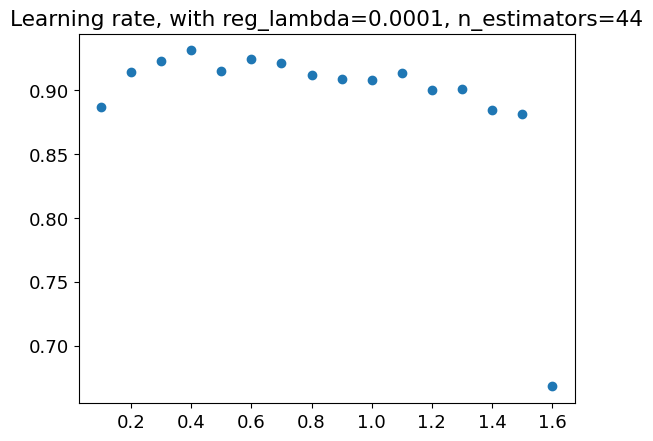

In [78]:
lr=np.array(lista_lr)
plt.scatter(lr[:,0],lr[:,1])
stringa='Learning rate, with reg_lambda='+str(reg_lambda)+', n_estimators='+str(n_estimators)
plt.title(stringa)
#plt.savefig('lr_1e-4_44')

In [79]:
with open('data_lr.txt',mode='a') as f:
    print(reg_lambda,n_estimators,file=f)
    print(lr,file=f)


In [80]:
lista_rl=[]

In [81]:
#change manually here
learning_rate=0.4
n_estimators=44

reg_lambdas=np.logspace(-9,1,num=11)
for reg_lambda in reg_lambdas:
    model = XGBClassifier(seed=1,
                        objective='binary:logistic',
                        importance_type="gain",
                        learning_rate=learning_rate,
                        reg_lambda=reg_lambda, 
                        n_estimators=n_estimators)

    model.fit(x_train,y_train)
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-model.score(x_test, y_test)),model.score(x_test, y_test)))
    a=model.score(x_test,y_test)
    lista_rl.append((reg_lambda,a)) 

errors: 7.52%   Accuracy=0.925
errors: 7.52%   Accuracy=0.925
errors: 7.52%   Accuracy=0.925
errors: 7.52%   Accuracy=0.925
errors: 7.68%   Accuracy=0.923
errors: 6.88%   Accuracy=0.931
errors: 7.28%   Accuracy=0.927
errors: 7.92%   Accuracy=0.921
errors: 8.08%   Accuracy=0.919
errors: 8.24%   Accuracy=0.918
errors: 8.80%   Accuracy=0.912


[(1e-09, 0.9248), (1e-08, 0.9248), (1e-07, 0.9248), (1e-06, 0.9248), (1e-05, 0.9232), (0.0001, 0.9312), (0.001, 0.9272), (0.01, 0.9208), (0.1, 0.9192), (1.0, 0.9176), (10.0, 0.912)]


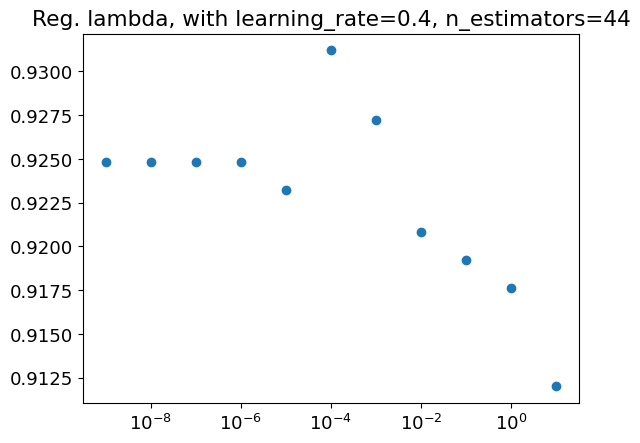

In [82]:
print(lista_rl)
rl=np.array(lista_rl)
plt.xscale('log')
plt.scatter(rl[:,0],rl[:,1])

stringa='Reg. lambda, with learning_rate='+str(learning_rate)+', n_estimators='+str(n_estimators)
plt.title(stringa)

plt.savefig('rl_4e-1_44_b')

In [83]:
with open('data_rl.txt',mode='w') as f:
    print(learning_rate,n_estimators,file=f)
    print(rl,file=f)

In [84]:
lista_ne=[]

In [85]:
#change manually here
learning_rate=0.4
reg_lambda=1e-4

#n_estimators=30
for n_estimators in range(2,51,2):
    model = XGBClassifier(seed=1,
                        objective='binary:logistic',
                        importance_type="gain", #weight, cover, ...
                        learning_rate=learning_rate,
                        reg_lambda=reg_lambda, 
                        n_estimators=n_estimators)

    model.fit(x_train,y_train)
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-model.score(x_test, y_test)),model.score(x_test, y_test)))
    a=model.score(x_test,y_test)
    lista_ne.append((n_estimators,a)) 

errors: 20.08%   Accuracy=0.799
errors: 15.76%   Accuracy=0.842
errors: 15.04%   Accuracy=0.850
errors: 13.12%   Accuracy=0.869
errors: 11.52%   Accuracy=0.885
errors: 11.04%   Accuracy=0.890
errors: 9.76%   Accuracy=0.902
errors: 9.92%   Accuracy=0.901
errors: 9.44%   Accuracy=0.906
errors: 9.12%   Accuracy=0.909
errors: 8.56%   Accuracy=0.914
errors: 8.48%   Accuracy=0.915
errors: 8.40%   Accuracy=0.916
errors: 8.00%   Accuracy=0.920
errors: 7.68%   Accuracy=0.923
errors: 7.36%   Accuracy=0.926
errors: 7.92%   Accuracy=0.921
errors: 7.60%   Accuracy=0.924
errors: 7.76%   Accuracy=0.922
errors: 7.28%   Accuracy=0.927
errors: 6.96%   Accuracy=0.930
errors: 6.88%   Accuracy=0.931
errors: 7.28%   Accuracy=0.927
errors: 7.20%   Accuracy=0.928
errors: 7.20%   Accuracy=0.928


[(2, 0.7992), (4, 0.8424), (6, 0.8496), (8, 0.8688), (10, 0.8848), (12, 0.8896), (14, 0.9024), (16, 0.9008), (18, 0.9056), (20, 0.9088), (22, 0.9144), (24, 0.9152), (26, 0.916), (28, 0.92), (30, 0.9232), (32, 0.9264), (34, 0.9208), (36, 0.924), (38, 0.9224), (40, 0.9272), (42, 0.9304), (44, 0.9312), (46, 0.9272), (48, 0.928), (50, 0.928)]


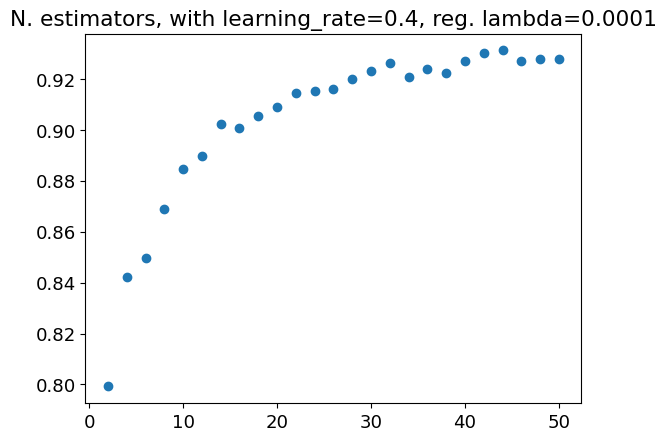

In [86]:
print(lista_ne)
ne=np.array(lista_ne)
plt.scatter(ne[:,0],ne[:,1])
stringa='N. estimators, with learning_rate='+str(learning_rate)+', reg. lambda='+str(reg_lambda)
plt.title(stringa)

plt.savefig('ne_4e-1_1e4')

In [87]:
with open('data_ne.txt',mode='w') as f:
    print(learning_rate,reg_lambda,file=f)
    print(ne,file=f)

### Comparing accuracies with and without regularization

In [88]:
scores_reg=[]
scores=[]
x=range(2,51,2)
for n_estimators in x:
    model = XGBClassifier(seed=1,
                    objective='binary:logistic',
                    importance_type="gain", #weight, cover, ...
                    learning_rate=0.4,
                    reg_lambda=1e-4, 
                    n_estimators=n_estimators)
    model.fit(x_train,y_train)
    sc_reg=model.score(x_test, y_test)
    scores_reg.append(sc_reg)

    model = XGBClassifier(seed=1,
                    objective='binary:logistic',
                    importance_type="gain", #weight, cover, ...
                    learning_rate=0.4,
                    reg_lambda=None, 
                    n_estimators=n_estimators)
    model.fit(x_train,y_train)
    sc=model.score(x_test, y_test)
    scores.append(sc)

Text(0, 0.5, 'Accuracies')

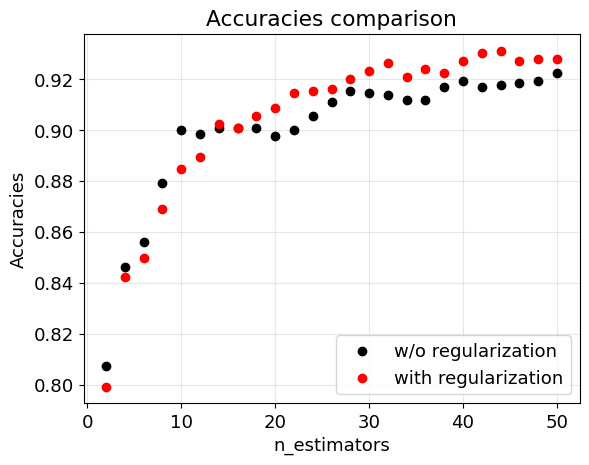

In [89]:
plt.title('Accuracies comparison')
plt.grid(True,alpha=0.3, zorder=2.03)

plt.scatter(x,scores,c='k',label='w/o regularization', zorder=2.01)
plt.scatter(x,scores_reg,c='r',label='with regularization', zorder=2.02)
plt.legend(loc='lower right')
plt.xlabel('n_estimators')
plt.ylabel('Accuracies')
#plt.savefig('accuracies comparison')


## Simplest model

errors: 19.28%   Accuracy=0.807


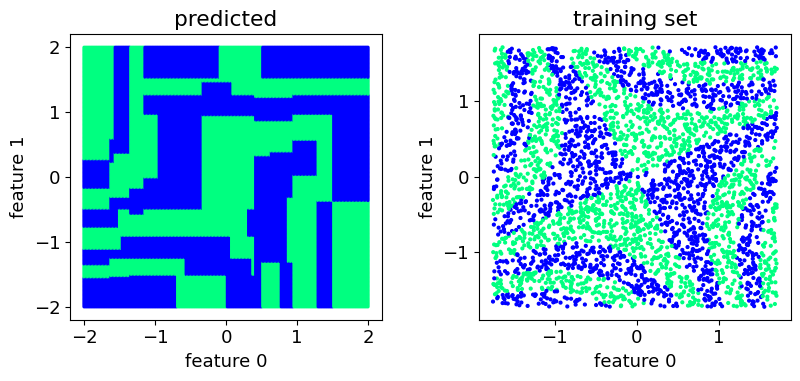

In [102]:
learning_rate=0.4
n_estimators=2
reg_lambda=None

simple_model = XGBClassifier(seed=1,
                    objective='binary:logistic',
                    importance_type="gain",
                    learning_rate=learning_rate,
                    reg_lambda=reg_lambda, 
                    n_estimators=n_estimators)

simple_model.fit(x_train,y_train)
y_hat = simple_model.predict(x_test)
    
#print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-simple_model.score(x_test, y_test)),simple_model.score(x_test, y_test)))
classify(clf=simple_model,show=False)

## Best model

errors: 6.88%   Accuracy=0.931


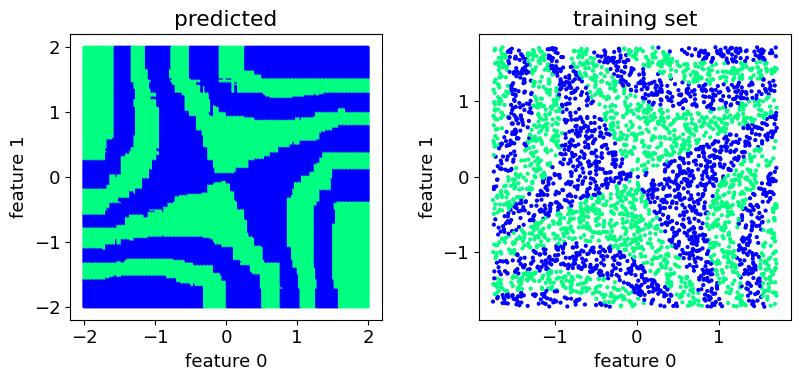

In [103]:
learning_rate=0.4
n_estimators=44
reg_lambda=1e-4

best_model = XGBClassifier(seed=1,
                    objective='binary:logistic',
                    importance_type="gain",
                    learning_rate=learning_rate,
                    reg_lambda=reg_lambda, 
                    n_estimators=n_estimators)
classify(clf=best_model,show=False)


gain
[0.4332652  0.4256838  0.07108153 0.06996945]


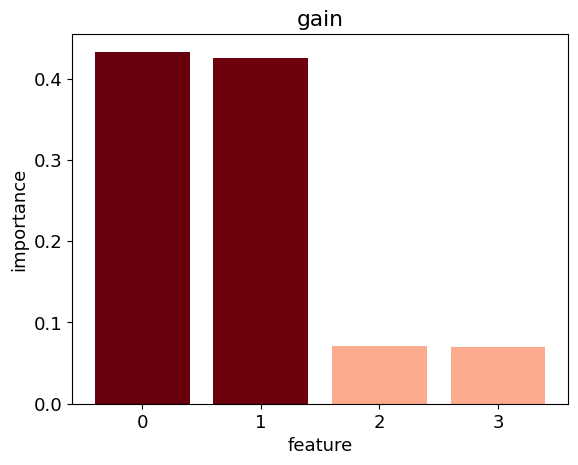

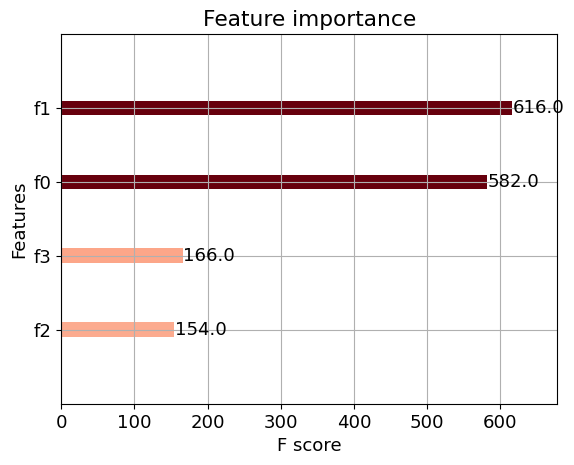

In [104]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# feature importance
print(best_model.importance_type)
print(best_model.feature_importances_)

# plot
my_cmap = plt.get_cmap("Reds")
rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))
plt.bar(range(len(best_model.feature_importances_)), best_model.feature_importances_,
        color=my_cmap(rescale(best_model.feature_importances_)))
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(np.arange(L))
plt.title(best_model.importance_type)
plt.show()

rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
plot_importance(best_model,color=my_cmap(rescale_r(best_model.feature_importances_)))
plt.show()

Documentation: https://xgboost.readthedocs.io/en/stable/python/python_api.html

    ‘weight’: the number of times a feature is used to split the data across all trees.

    ‘gain’: the average gain across all splits the feature is used in.

    ‘cover’: the average coverage across all splits the feature is used in.

    ‘total_gain’: the total gain across all splits the feature is used in.

    ‘total_cover’: the total coverage across all splits the feature is used in.


0 weight [582. 616. 154. 166.]
1 gain [5.93998814 5.83604813 0.97451496 0.95926857]
2 total_gain [3457.07299805 3595.00561523  150.07530212  159.23858643]
3 cover [71.7477417  72.29241943 76.56706238 54.8244133 ]
4 total_cover [41757.1875     44532.12890625 11791.32714844  9100.85253906]


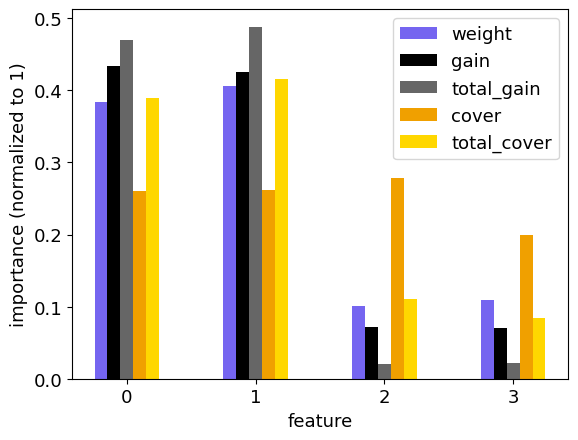

In [105]:
# if the importance type is “total_gain”, then the score is sum of loss change for each split from all trees.
list_type=["weight","gain","total_gain","cover","total_cover"]
list_col=["#7565F0","k","#666666","#F0A000","gold"]

for i,t in enumerate(list_type):
    feature_imp = best_model.get_booster().get_score(importance_type=t)
    keys = list(feature_imp.keys())
    values = np.array(list(feature_imp.values()))
    print(i,t,values)
    values= values/np.sum(values)
    plt.bar(np.arange(L)+(i-L/2)/10, values,color=list_col[i],width=0.1,label=t)
plt.xlabel("feature")
plt.ylabel("importance (normalized to 1)")
plt.xticks(np.arange(L))
plt.legend()
plt.show()

## 2. dimensionality reduction

In [106]:
dname="./DATA/"
str0="_XGB_25.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)

# REMOVING ONE FEATURE (feature 2)
x=np.delete(x,2,axis=1)

N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")


N=5000, N_train=3750, L=3


In [107]:
learning_rate=0.4
n_estimators=44
reg_lambda=1e-4

reduced_best_model = XGBClassifier(seed=1,
                    objective='binary:logistic',
                    importance_type="gain",
                    learning_rate=learning_rate,
                    reg_lambda=reg_lambda, 
                    n_estimators=n_estimators)
#classify(clf=reduced_best_model,show=False)

reduced_best_model.fit(x_train,y_train)
y_hat = reduced_best_model.predict(x_test)
    
print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-reduced_best_model.score(x_test, y_test)),reduced_best_model.score(x_test, y_test)))

errors: 7.28%   Accuracy=0.927


gain
[0.4542527  0.47359177 0.07215555]


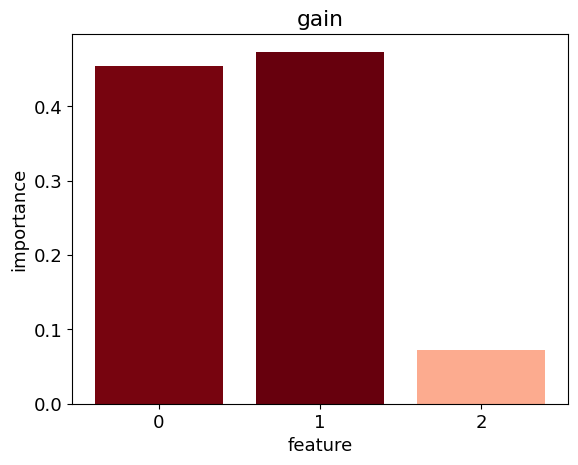

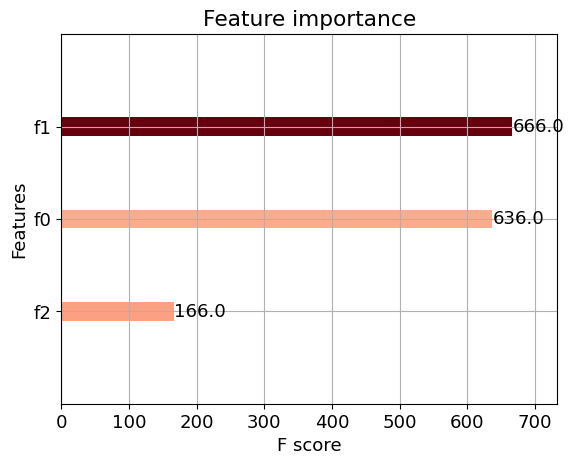

In [108]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# feature importance
print(reduced_best_model.importance_type)
print(reduced_best_model.feature_importances_)

# plot
my_cmap = plt.get_cmap("Reds")
rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))
plt.bar(range(len(reduced_best_model.feature_importances_)), reduced_best_model.feature_importances_,
        color=my_cmap(rescale(reduced_best_model.feature_importances_)))
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(np.arange(L))
plt.title(reduced_best_model.importance_type)
plt.show()

rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
plot_importance(reduced_best_model,color=my_cmap(rescale_r(reduced_best_model.feature_importances_)))
plt.show()

0 weight [636. 666. 166.]
1 gain [5.41434526 5.64485216 0.86003906]
2 total_gain [3443.52368164 3759.47143555  142.76647949]
3 cover [69.13506317 70.91998291 63.70800018]
4 total_cover [43969.90234375 47232.7109375  10575.52832031]


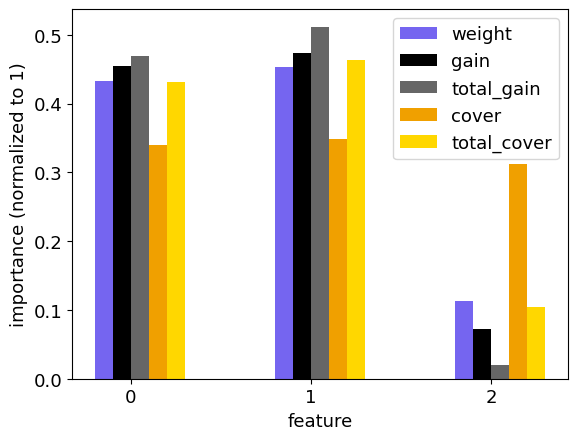

In [109]:
# if the importance type is “total_gain”, then the score is sum of loss change for each split from all trees.
list_type=["weight","gain","total_gain","cover","total_cover"]
list_col=["#7565F0","k","#666666","#F0A000","gold"]

for i,t in enumerate(list_type):
    feature_imp = reduced_best_model.get_booster().get_score(importance_type=t)
    keys = list(feature_imp.keys())
    values = np.array(list(feature_imp.values()))
    print(i,t,values)
    values= values/np.sum(values)
    plt.bar(np.arange(L)+(i-L/2)/10, values,color=list_col[i],width=0.1,label=t)
plt.xlabel("feature")
plt.ylabel("importance (normalized to 1)")
plt.xticks(np.arange(L))
plt.legend()
plt.show()

In [110]:
learning_rate=0.4
n_estimators=2
reg_lambda=None

reduced_simple_model = XGBClassifier(seed=1,
                    objective='binary:logistic',
                    importance_type="gain",
                    learning_rate=learning_rate,
                    reg_lambda=reg_lambda, 
                    n_estimators=n_estimators)

reduced_simple_model.fit(x_train,y_train)
y_hat = reduced_simple_model.predict(x_test)
    
print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-reduced_simple_model.score(x_test, y_test)),reduced_simple_model.score(x_test, y_test)))

errors: 19.28%   Accuracy=0.807


gain
[0.48489535 0.51510465 0.        ]


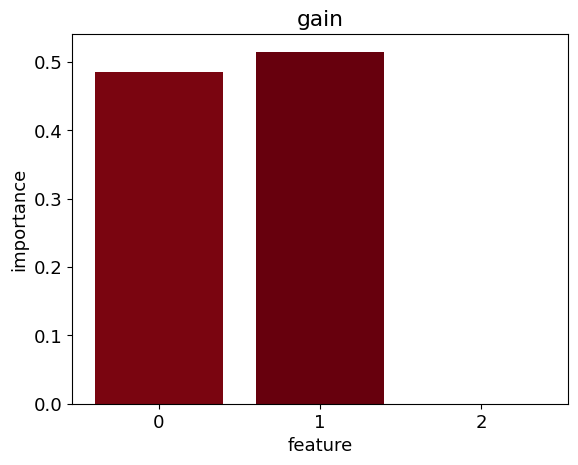

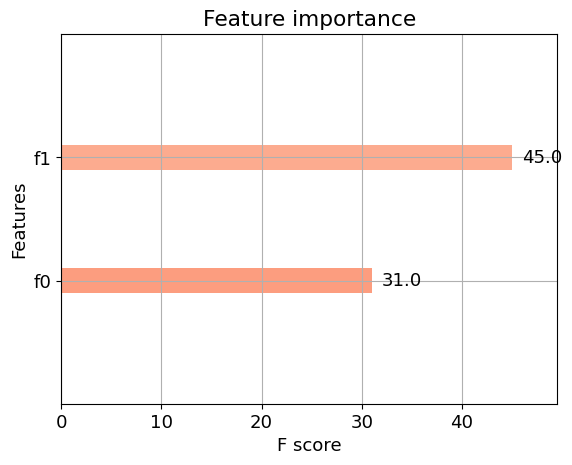

In [111]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# feature importance
print(reduced_simple_model.importance_type)
print(reduced_simple_model.feature_importances_)

# plot
my_cmap = plt.get_cmap("Reds")
rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))
plt.bar(range(len(reduced_simple_model.feature_importances_)), reduced_simple_model.feature_importances_,
        color=my_cmap(rescale(reduced_simple_model.feature_importances_)))
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(np.arange(L))
plt.title(reduced_simple_model.importance_type)
plt.show()

rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
plot_importance(reduced_simple_model,color=my_cmap(rescale_r(reduced_simple_model.feature_importances_)))
plt.show()

0 weight [31. 45.]
1 gain [27.42430878 29.13286209]
2 total_gain [ 850.15356445 1310.97875977]
3 cover [183.27957153 115.35945129]
4 total_cover [5681.66650391 5191.17529297]


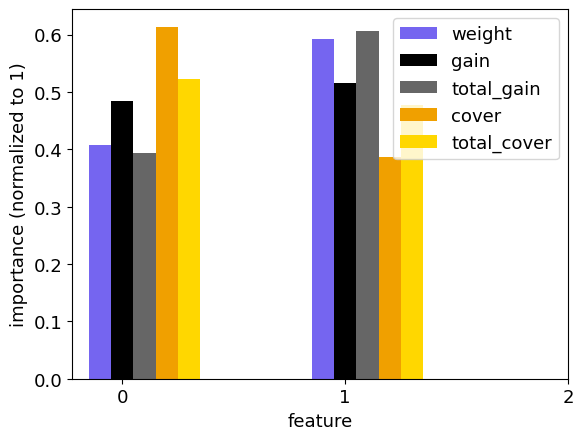

In [112]:
# if the importance type is “total_gain”, then the score is sum of loss change for each split from all trees.
list_type=["weight","gain","total_gain","cover","total_cover"]
list_col=["#7565F0","k","#666666","#F0A000","gold"]

for i,t in enumerate(list_type):
    feature_imp = reduced_simple_model.get_booster().get_score(importance_type=t)
    keys = list(feature_imp.keys())
    values = np.array(list(feature_imp.values()))
    print(i,t,values)
    values= values/np.sum(values)
    plt.bar(np.arange(L-1)+(i-(L-1)/2)/10, values,color=list_col[i],width=0.1,label=t)
plt.xlabel("feature")
plt.ylabel("importance (normalized to 1)")
plt.xticks(np.arange(L))
plt.legend()
plt.show()

## 3. XGBoost vs NN

In [114]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

def build_model():
    model = Sequential()
    L = 3 #num features
    
    # Input layer
    model.add(Dense(L, input_shape=(L,), activation='relu'))
    hidd_active = 'elu'
    
    # 3 hidden layers
    for layer_num in range(1, 4):
        model.add(Dense(20, activation=hidd_active))
        if layer_num !=3:
            model.add(Dropout(0.0))
        else:
            model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(1,activation='sigmoid'))
    learning_rate = 0.1
    hyper_optimizer = 'RMSprop'
        
    model.compile(loss='binary_crossentropy', optimizer=hyper_optimizer, metrics=["accuracy"])
    return model

In [115]:
best_model = build_model()
fit = best_model.fit(x_train, y_train, batch_size = 50, validation_data=(x_test,y_test), verbose=0) # Training best model and evaluating it using the test dataset

/home/gigi/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [116]:
def k_fold_cross_validation(x_train, y_train, k, models):
    # Initialize holders
    best = -1 # Best model
    best_perf = -1 # Best score
    results = [] # List to store performance of each model
    histories = []
    # Divide training set in K folds
    idx = rng.permutation(np.arange(x_train.shape[0]))
    x_folds, y_folds = np.array_split(x_train[idx, :], k), np.array_split(y_train[idx], k)
    
    for i in range(len(models)):
        model_perf = []  # Stores each k-th score
        for test in range(k):
            # Define validation and training set
            x_train_fold = np.concatenate([x for i, x in enumerate(x_folds) if i != test])
            y_train_fold = np.concatenate([x for i, x in enumerate(y_folds) if i != test])
            x_validate_fold, y_validate_fold = x_folds[test], y_folds[test]
            k_model = best_model
            k_model.fit(x_train_fold, y_train_fold, epochs=400, verbose=0, validation_data=(x_validate_fold, y_validate_fold), callbacks=EarlyStopping(patience=5))
            # Accumulates the performance
            model_perf.append(k_model.evaluate(x_validate_fold, y_validate_fold, verbose=0)[1])        
        results.append(((curr_perf := np.mean(model_perf)), np.std(model_perf))) # Average and std over the k-folds
        # if the current model performs better than best, updates best__
        if (best_perf < curr_perf): best, best_perf = models[i], curr_perf
        #Below: return best model, its index, and list of performance results for each model
    return best, results

best_model, results = k_fold_cross_validation(x_train, y_train, 5, models)
print(results) #Performance of each model.

NameError: name 'models' is not defined